In [ ]:
#keyword extraction from the data
import requests
import pandas as pd
from datetime import datetime, timedelta

# Define your keywords and date range
keywords = ["rent","property_price","income","mortgage","observations","housing_price","students","visa","migration","immigration","rental_price","studying"]
start_year = 2020
end_year = 2023

# Function to generate monthly date ranges
def generate_monthly_date_ranges(start_year, end_year):
    date_ranges = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            start_date = datetime(year, month, 1)
            end_date = start_date + timedelta(days=32)
            end_date = end_date.replace(day=1) - timedelta(days=1)
            date_ranges.append((start_date, end_date))
    return date_ranges

# Function to get keyword count data
def get_keyword_counts(keyword, start_date, end_date):
    url = f"http://127.0.0.1:9090/toot/{keyword}?start_date={start_date}&end_date={end_date}&type=count"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        if isinstance(data, dict):
            return data.get('count', 0)
        elif isinstance(data, list) and len(data) > 0:
            return data[0].get('count', 0)
        else:
            return 0
    else:
        return None

# Generate the monthly date ranges
date_ranges = generate_monthly_date_ranges(start_year, end_year)

# Create a DataFrame to store the results
results = []

# Fetch data for each keyword and date range
for keyword in keywords:
    for start_date, end_date in date_ranges:
        count = get_keyword_counts(keyword, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))
        if count is not None:
            results.append({
                'keyword': keyword,
                'start_date': start_date.strftime("%Y-%m-%d"),
                'end_date': end_date.strftime("%Y-%m-%d"),
                'count': count
            })

# Convert results to DataFrame
df = pd.DataFrame(results)

# Display the DataFrame
print(df)

# Optionally, save the DataFrame to a CSV file
df.to_csv('keyword_counts.csv', index=False)


In [80]:
#sentiment analysis
import requests
import pandas as pd
from datetime import datetime, timedelta
import re
from textblob import TextBlob

# Define your keywords and date range
keywords = ["rent","property_price","income","mortgage","observations","housing_price","students","visa","migration","immigration","rental_price","studying"]
start_year = 2020
end_year = 2023

# Function to generate monthly date ranges
def generate_monthly_date_ranges(start_year, end_year):
    date_ranges = []
    for year in range(start_year, end_year + 1):
        for month in range(1, 13):
            start_date = datetime(year, month, 1)
            end_date = start_date + timedelta(days=32)
            end_date = end_date.replace(day=1) - timedelta(days=1)
            date_ranges.append((start_date, end_date))
    return date_ranges

# Function to remove HTML tags
def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)


# Function to get sentimental scores
def fetch_data(keyword, start_date, end_date):
    url = f"http://127.0.0.1:9090/toot/{keyword}?start_date={start_date}&end_date={end_date}&type=raw"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch data for keyword '{keyword}' in date range {start_date} to {end_date}")
        return None
    
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity
    
data_range = generate_monthly_date_ranges(start_year, end_year)

sentimetal_scores_list = []

for keyword in keywords:
    for start_date, end_date in data_range:
        data = fetch_data(keyword, start_date.strftime("%Y-%m-%d"), end_date.strftime("%Y-%m-%d"))
        if data:
            total_polarity = 0
            count = 0
            for item in data:
                content = item.get("content", "")
                cleaned_text = remove_html(content)
                sentiment_score = get_sentiment(cleaned_text)
                total_polarity += sentiment_score
                count += 1
            if count > 0:
                average_polarity = total_polarity / count
                sentimetal_scores_list.append({
                    'keyword': keyword,
                    'start_date': start_date.strftime("%Y-%m-%d"),
                    'end_date': end_date.strftime("%Y-%m-%d"),
                    'average_polarity': average_polarity
                })

df = pd.DataFrame(sentimetal_scores_list)
df.to_csv('sentiment_scores.csv', index=False)
    

In [75]:
#Unite the two dataframes
import pandas as pd

# Read the CSV files
keyword_counts = pd.read_csv('keyword_counts.csv')
sentiment_scores = pd.read_csv('sentiment_scores.csv')

# Merge the two dataframes on keyword, start_date, and end_date
merged_df = pd.merge(keyword_counts, sentiment_scores, on=['keyword', 'start_date', 'end_date'], how='left')

# Fill NaN values in average_polarity with 0
merged_df['average_polarity'] = merged_df['average_polarity'].fillna(0)

# Save the merged dataframe to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)


Plot saved as output/keyword_count_change_plot.html


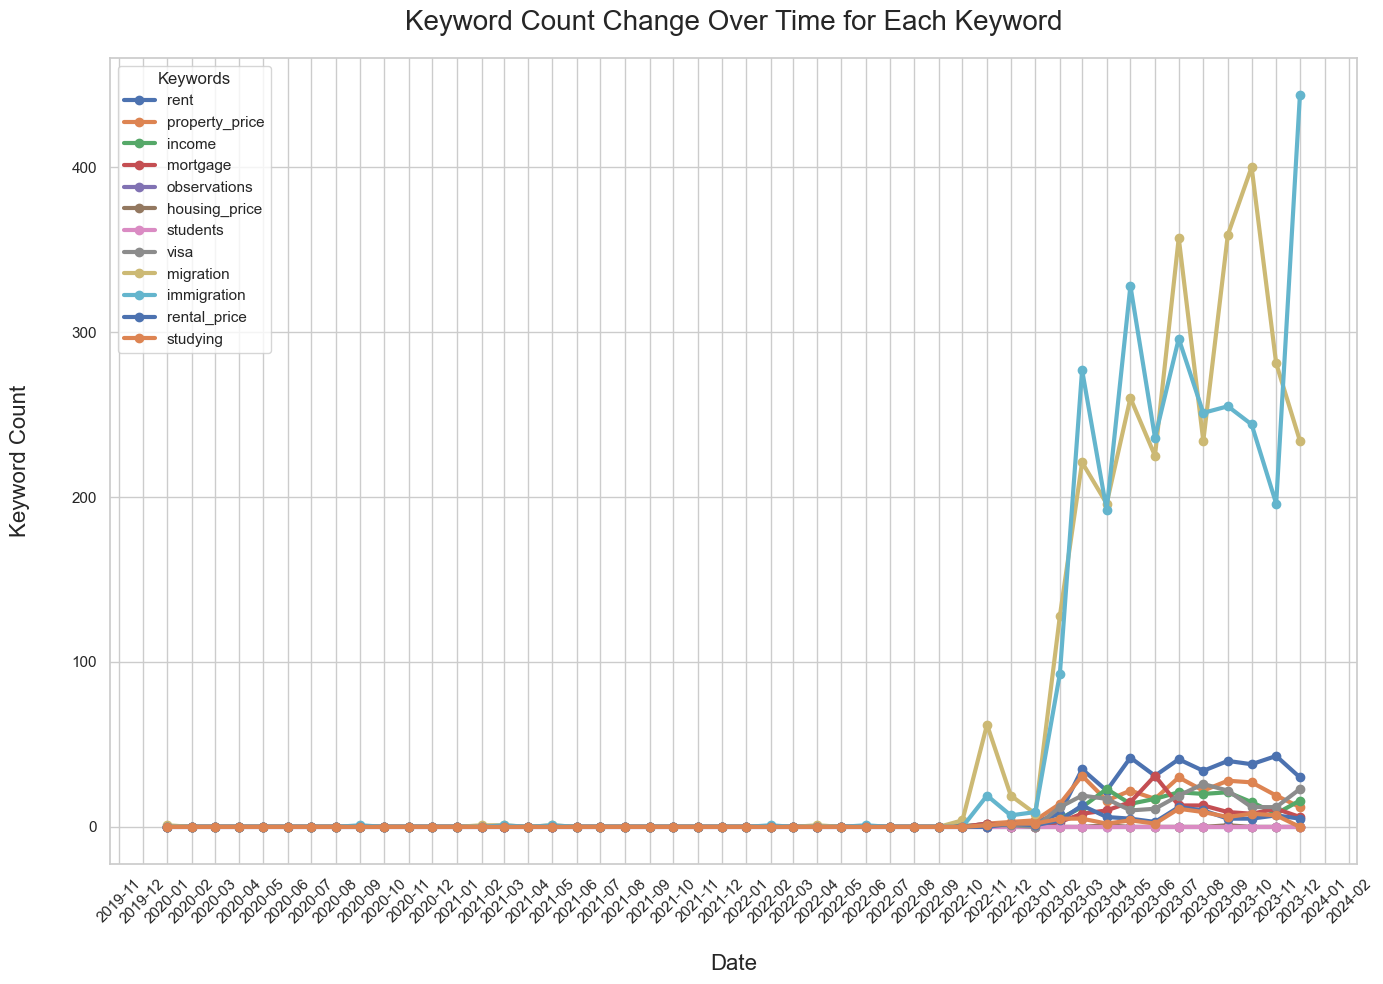

In [76]:
#keyword count plot graph
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

# Load the data from CSV
df = pd.read_csv('merged_data.csv')

# Convert the start_date to datetime for better plotting
df['start_date'] = pd.to_datetime(df['start_date'])

# Create the plot
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10", len(df['keyword'].unique()))

for keyword in df['keyword'].unique():
    keyword_data = df[df['keyword'] == keyword]
    plt.plot(keyword_data['start_date'], keyword_data['count'], label=keyword,linewidth=3, marker='o', markersize=6)

plt.xlabel('Date', fontsize=16, labelpad=20)
plt.ylabel('Keyword Count', fontsize=16, labelpad=30)
plt.title('Keyword Count Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.legend(title='Keywords',loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)

# Set major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/keyword_count_change_plot.html'
mpld3.save_html(plt.gcf(), html_filename)

print(f"Plot saved as {html_filename}")

Plot saved as output/sentiment_socre_change_plot.html


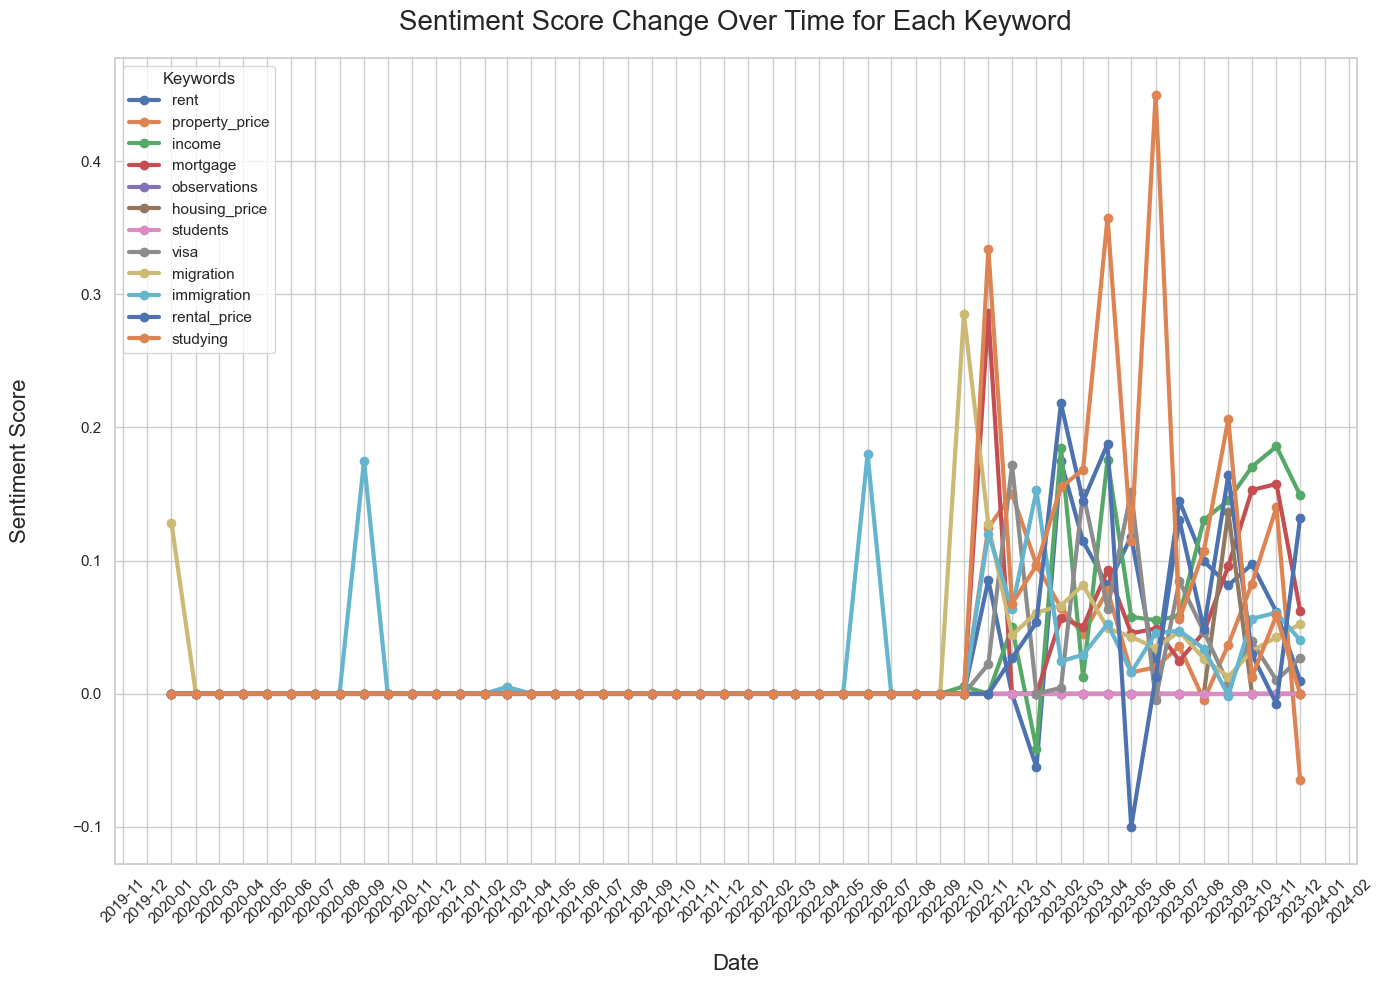

In [81]:
#sentimental score plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

# Load the data from CSV
df = pd.read_csv('merged_data.csv')

# Convert the start_date to datetime for better plotting
df['start_date'] = pd.to_datetime(df['start_date'])

# Create the plot
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
color_palette = sns.color_palette("tab10", len(df['keyword'].unique()))

for keyword in df['keyword'].unique():
    keyword_data = df[df['keyword'] == keyword]
    plt.plot(keyword_data['start_date'], keyword_data['average_polarity'], label=keyword,linewidth=3, marker='o', markersize=6)

plt.xlabel('Date', fontsize=16, labelpad=20)
plt.ylabel('Sentiment Score', fontsize=16, labelpad=30)
plt.title('Sentiment Score Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.legend(title='Keywords', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)

# Set major locator to month intervals
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/sentiment_socre_change_plot.html'
mpld3.save_html(plt.gcf(), html_filename)

print(f"Plot saved as {html_filename}")

Plot saved as output/sentiment_score_count_combined_plot.html


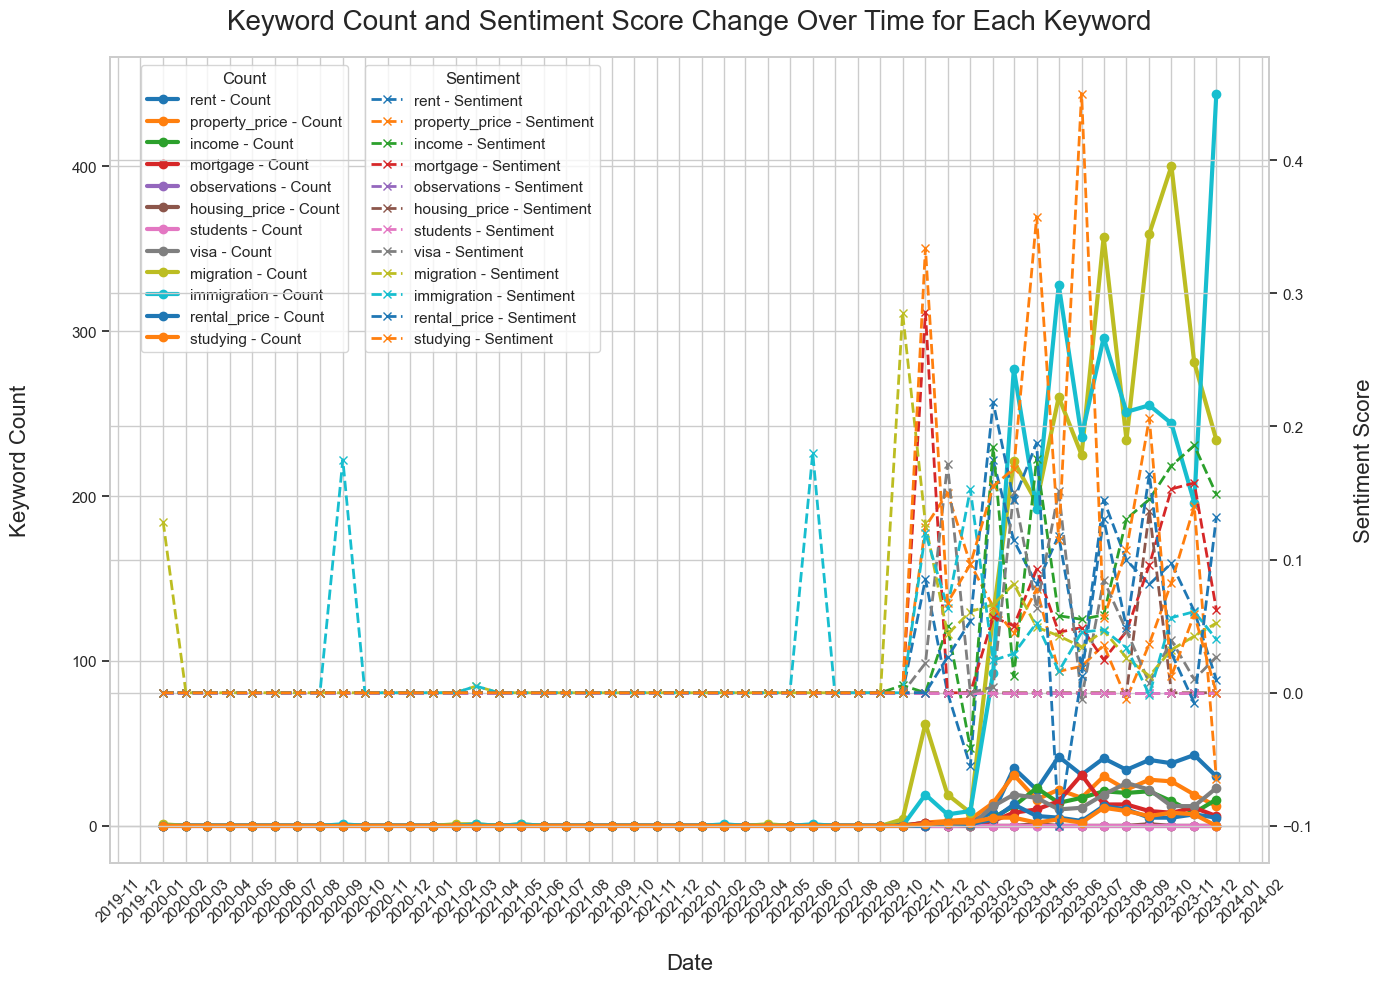

In [82]:
#merged data plot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import matplotlib.dates as mdates

# Load the data from CSV
df = pd.read_csv('merged_data.csv')

# Convert the start_date to datetime for better plotting
df['start_date'] = pd.to_datetime(df['start_date'])

# Create a color palette for each keyword
color_palette = sns.color_palette("tab10", len(df['keyword'].unique()))

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 10))
sns.set(style="whitegrid")

# Plot keyword count on the primary y-axis
for i, keyword in enumerate(df['keyword'].unique()):
    keyword_data = df[df['keyword'] == keyword]
    ax1.plot(keyword_data['start_date'], keyword_data['count'], label=f"{keyword} - Count", linewidth=3, marker='o', markersize=6, color=color_palette[i])

ax1.set_xlabel('Date', fontsize=16, labelpad=20)
ax1.set_ylabel('Keyword Count', fontsize=16, labelpad=30)
ax1.legend(loc='upper left', bbox_to_anchor=(0.02, 1), title='Count')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True)

# Create secondary y-axis for sentiment score
ax2 = ax1.twinx()

# Plot sentiment score on the secondary y-axis
for i, keyword in enumerate(df['keyword'].unique()):
    keyword_data = df[df['keyword'] == keyword]
    ax2.plot(keyword_data['start_date'], keyword_data['average_polarity'], label=f"{keyword} - Sentiment", linestyle='--', linewidth=2, marker='x', markersize=6, color=color_palette[i])

ax2.set_ylabel('Sentiment Score', fontsize=16, labelpad=30)
ax2.legend(loc='upper left', bbox_to_anchor=(0.22, 0.99), title='Sentiment', borderaxespad=0.)

plt.title('Keyword Count and Sentiment Score Change Over Time for Each Keyword', fontsize=20, pad=20)
plt.tight_layout()

# Save the plot as an HTML file
html_filename = 'output/sentiment_score_count_combined_plot.html'
mpld3.save_html(fig, html_filename)

print(f"Plot saved as {html_filename}")
